In [1]:
%matplotlib notebook
import keras as keras
from keras.models import Sequential
from keras.layers import LSTM, Dense,BatchNormalization,Dropout,Flatten, Conv1D, Conv2D, MaxPool2D
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras import regularizers,optimizers
from keras.regularizers import l2
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import gzip
from keras.layers.core import Lambda

from keras.layers.core import Lambda
from keras import backend as K

Using TensorFlow backend.


In [2]:
FullInputs = scipy.io.loadmat('MNIST_TrainInputs.mat')
FullInputs = FullInputs['images']

FullTargets = scipy.io.loadmat('MNIST_TrainTargets.mat')
FullTargets = FullTargets['targets']

In [3]:
Validation_Cutoff = 0.5

Validation_Cutoff = np.int(Validation_Cutoff*FullInputs.shape[0])

ValInputs = FullInputs[Validation_Cutoff:,:]
ValTargets = FullTargets[Validation_Cutoff:,:]

TrainInputs = FullInputs[0:Validation_Cutoff,:]
TrainTargets = FullTargets[0:Validation_Cutoff,:]


In [4]:
TrainInputs = TrainInputs.reshape([TrainInputs.shape[0],28,28,1])
TrainInputs = np.swapaxes(TrainInputs,1,2)

ValInputs = ValInputs.reshape([ValInputs.shape[0],28,28,1])
ValInputs = np.swapaxes(ValInputs,1,2)

In [5]:
data_dim = TrainInputs.shape[1]
data_dim2 = TrainInputs.shape[2]
NumSamples = TrainInputs.shape[0]
Num_Targets = TrainTargets.shape[-1]

index = np.linspace(0,NumSamples,NumSamples,endpoint=False,dtype=int)

reg_coeff = 0.0005

def Gen_Model(reg_coeff):
    model = Sequential()
    model.add(Conv2D(32,3,activation='relu',input_shape =(data_dim,data_dim2,1)))
#     model.add(MaxPool2D())
#     model.add(Conv2D(64,5,activation='relu'))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(100,activation='relu',kernel_regularizer=l2(reg_coeff)))
    model.add(Dropout(0.3))
    model.add(Dense(Num_Targets,activation = 'softmax',kernel_regularizer=l2(reg_coeff),input_shape =(data_dim,)))
    optim = optimizers.adam(lr=0.0001)
    model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['categorical_accuracy'])
    
    return model
    
Hard_model = Gen_Model(reg_coeff)    
Easy_model = Gen_Model(reg_coeff)
UniHard_model = Gen_Model(reg_coeff)    
UniEasy_model = Gen_Model(reg_coeff)
# ISHard_model = Gen_Model(reg_coeff)    
# ISEasy_model = Gen_Model(reg_coeff)
Uni_model = Gen_Model(reg_coeff)  


Hard_model.set_weights(Uni_model.get_weights())
Easy_model.set_weights(Uni_model.get_weights())
UniHard_model.set_weights(Uni_model.get_weights())
UniEasy_model.set_weights(Uni_model.get_weights())


In [6]:
def acquisition_function_dist_to_threshold(model,samples,Num_Targets,temperature=1,Target_Ratio=5):
    Output = model.predict(samples)
    Output -= 1/float(Num_Targets)
    Dist_to_Threshold = np.sum(np.abs(Output),1)
    Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
    Exp_Dist_to_Threshold *= 1
#     Exp_Dist_to_Threshold = Dist_to_Threshold
    Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
    Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
    Target_Ratio = Target_Ratio
    if Max_Prob_Ratio < Target_Ratio:
        while Max_Prob_Ratio <Target_Ratio:
            temperature = temperature*0.99
            Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
            StoreSampling_Prob = Sampling_Prob.copy()
            Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
            if np.isnan(Max_Prob_Ratio):
                Sampling_Prob = StoreSampling_Prob.copy()
    else:
        while Max_Prob_Ratio > Target_Ratio:
            temperature = temperature*1.01
            Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
            StoreSampling_Prob = Sampling_Prob.copy()
            Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
            if np.isnan(Max_Prob_Ratio):
                Sampling_Prob = StoreSampling_Prob.copy()
    return Sampling_Prob


def Exp_ModelChange(Model,Inputs,Num_Targets):
    ExpChange = np.zeros(Inputs.shape[0])
    for TargetLoop in range(Num_Targets):
        thisTarget = np.zeros([Inputs.shape[0],Num_Targets])
        thisTarget[:,TargetLoop] = 1
        Model_Output = Model.predict(Inputs)
        ClassProb = Model_Output[:,TargetLoop]
        Loss = np.mean(Model_Output - Model_Output*thisTarget + np.log(1+np.exp(-Model_Output)),1)
        ExpChange += Loss*ClassProb
    return ExpChange

def acquisition_function_exp_model_change(model,samples,Num_Targets,Smoothing_Const=0,Rescale=0):
    ExpChange = Exp_ModelChange(model,samples,Num_Targets) + Smoothing_Const
    Sampling_Prob = ExpChange/np.sum(ExpChange)
    if Rescale == 1:
        Median_Prob = np.median(Sampling_Prob)
        Min_Prob = np.min(Sampling_Prob)
        Sampling_Prob[Sampling_Prob > Median_Prob] += Min_Prob/2
        Sampling_Prob[Sampling_Prob < Median_Prob] -= Min_Prob/2
    return Sampling_Prob

def acquisition_function_exp_model_change(model,samples,Num_Targets,Smoothing_Const=0,Rescale=0):
    ExpChange = Exp_ModelChange(model,samples,Num_Targets) + Smoothing_Const
    ExpChange = ExpChange/np.sum(ExpChange)
    
    if Rescale == 1:
        Median_Prob = np.median(ExpChange)
        Min_Prob = np.min(ExpChange)
        ExpChange[ExpChange > Median_Prob] += Min_Prob/2
        ExpChange[ExpChange < Median_Prob] -= Min_Prob/2
    return ExpChange

def acquisition_function_BALD(model,samples,Num_Targets,temperature=1,Target_Ratio = 5):
    nb_MC_samples = 100
    MC_output = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])
    MC_samples = np.zeros([nb_MC_samples,samples.shape[0],Num_Targets])
    learning_phase = True 
    for i in range(nb_MC_samples):
        MC_samples[i,:,:] = np.array([MC_output([samples, learning_phase])[0]])
        print(i)
    expected_entropy = - np.mean(np.sum(MC_samples * np.log(MC_samples + 1e-10), axis=-1), axis=0)  # [batch size]
    expected_p = np.mean(MC_samples, axis=0)
    entropy_expected_p = - np.sum(expected_p * np.log(expected_p + 1e-10), axis=-1)  # [batch size]
    BALD_acq = entropy_expected_p - expected_entropy
    
    Exp_BALD = np.exp(BALD_acq/temperature)
    Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)
    
    Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
    Target_Ratio = Target_Ratio
    if Max_Prob_Ratio < Target_Ratio:
        while Max_Prob_Ratio <Target_Ratio:
            temperature = temperature*0.99
            Exp_BALD = np.exp(BALD_acq/temperature)
            StoreSampling_Prob = Sampling_Prob.copy()
            Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
            if np.isnan(Max_Prob_Ratio):
                Sampling_Prob = StoreSampling_Prob.copy()
    else:
        while Max_Prob_Ratio > Target_Ratio:
            temperature = temperature*1.01
            Exp_BALD = np.exp(BALD_acq/temperature)
            StoreSampling_Prob = Sampling_Prob.copy()
            Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
            if np.isnan(Max_Prob_Ratio):
                Sampling_Prob = StoreSampling_Prob.copy()
    return Sampling_Prob


In [7]:
count = 0 
Num_Epochs = 100
Num_BurnIn = 1
Batch_Size = 64

Smoothing_Constant = 0

Val_Error = np.zeros([Num_Epochs,3])
Val_Acc = np.zeros([Num_Epochs,3])

<IPython.core.display.Javascript object>


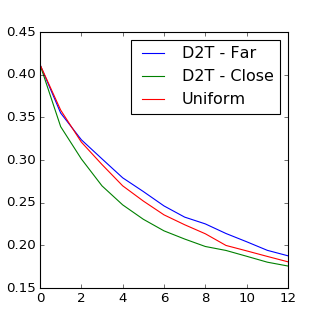

<IPython.core.display.Javascript object>


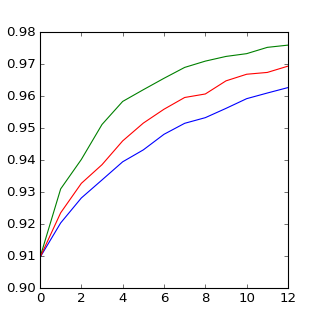

Epoch:
11
Training:
D2T - Far
Epoch 1/1
468/468 [==============================] - 14s 30ms/step - loss: 0.1626 - categorical_accuracy: 0.9750
D2T - Close
Epoch 1/1
468/468 [==============================] - 14s 30ms/step - loss: 0.2653 - categorical_accuracy: 0.9476
Uni Benchmark
Epoch 1/1
468/468 [==============================] - 15s 32ms/step - loss: 0.2134 - categorical_accuracy: 0.9603
11
Epoch:
12
Training:
D2T - Far
Epoch 1/1
468/468 [==============================] - 15s 32ms/step - loss: 0.1594 - categorical_accuracy: 0.9737
D2T - Close
Epoch 1/1
468/468 [==============================] - 15s 31ms/step - loss: 0.2552 - categorical_accuracy: 0.9489
Uni Benchmark
Epoch 1/1
468/468 [==============================] - 15s 31ms/step - loss: 0.2023 - categorical_accuracy: 0.9628
12
Epoch:
13
Training:
D2T - Far
Epoch 1/1
468/468 [==============================] - 15s 33ms/step - loss: 0.1547 - categorical_accuracy: 0.9753
D2T - Close
Epoch 1/1
468/468 [==============================

KeyboardInterrupt: 

In [12]:
fig = plt.figure(figsize = [4,4])
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

fig2 = plt.figure(figsize = [4,4])
ax2 = fig2.add_subplot(111)
plt.ion()
fig2.show()
fig2.canvas.draw()


def Biased_Batch(Inputs,Targets,Batch_Size,Sampling_Probability,Weighting_Flag = 1):
    while True: 
        index = np.linspace(0,Inputs.shape[0],Inputs.shape[0],endpoint=False,dtype=int)
        Batch = np.random.choice(index,size=Batch_Size,replace=False,p=Sampling_Probability)
        Batch_Inputs = Inputs[Batch,:]
        Batch_Targets = Targets[Batch,:]
        if Weighting_Flag == 1:
            FullWeights = Sampling_Probability**-1
            FullWeights = FullWeights/np.mean(FullWeights)
        elif Weighting_Flag == -1:
            FullWeights = Sampling_Probability/np.mean(Sampling_Probability)
        else:
            FullWeights = np.ones(Inputs.shape[0])
            
        Weights = FullWeights[Batch]
        yield (Batch_Inputs,Batch_Targets,Weights)


for EpochLoop in  range(Num_Epochs):
    if count < Num_BurnIn:
        Uni_model.fit(TrainInputs,TrainTargets,batch_size = 32,epochs=1,verbose=1)
        Error = Uni_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,:] = Error[0]
        Val_Acc[count,:] = Error[1]
        
        Hard_model.set_weights(Uni_model.get_weights())
        Easy_model.set_weights(Uni_model.get_weights())
        UniHard_model.set_weights(Uni_model.get_weights())
        UniEasy_model.set_weights(Uni_model.get_weights())
    else:
        Sampling_Probability = acquisition_function_dist_to_threshold(Hard_model,TrainInputs,Num_Targets,1,10)
        Inverse_SamplingProbability = 1/acquisition_function_dist_to_threshold(Easy_model,TrainInputs,Num_Targets,1,10)
        Inverse_SamplingProbability = Inverse_SamplingProbability/Inverse_SamplingProbability.sum().astype(float)
        
#         BaldSampling_Probability = acquisition_function_BALD(UniHard_model,TrainInputs,Num_Targets,1,10)
#         BaldInverse_SamplingProbability = 1/acquisition_function_BALD(UniEasy_model,TrainInputs,Num_Targets,1,10)
#         BaldInverse_SamplingProbability = BaldInverse_SamplingProbability/BaldInverse_SamplingProbability.sum().astype(float)
        
        print('Epoch:')
        print(count)
        print('Training:')
        print('D2T - Far')
        Hard_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,Sampling_Probability,0),
                                 steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=1)
        print('D2T - Close')
        Easy_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,Inverse_SamplingProbability,0),
                                 steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=1)
#         print('BALD - High')
#         UniHard_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,Sampling_Probability,0),
#                                  steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=1)
#         print('BALD - Low')
#         UniEasy_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,Inverse_SamplingProbability,0),
#                                  steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=1)
        print('Uni Benchmark')
        Uni_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,1/np.float(NumSamples)*np.ones(NumSamples)),
                                steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=1)
        
        Error = Hard_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,0] = Error[0]
        Val_Acc[count,0] = Error[1]
        
        Error = Easy_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,1] = Error[0]
        Val_Acc[count,1] = Error[1]
        
#         Error = UniHard_model.test_on_batch(ValInputs,ValTargets)
#         Val_Error[count,2] = Error[0]
#         Val_Acc[count,2] = Error[1]
        
#         Error = UniEasy_model.test_on_batch(ValInputs,ValTargets)
#         Val_Error[count,3] = Error[0]
#         Val_Acc[count,3] = Error[1]
        
        Error = Uni_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,2] = Error[0]
        Val_Acc[count,2] = Error[1]
            
    print(count)
    
    ax.clear()
    ax.plot(Val_Error[0:count,0],label='D2T - Far')
    ax.plot(Val_Error[0:count,1],label='D2T - Close')
#     ax.plot(Val_Error[0:count,2],label='BALD - High')
#     ax.plot(Val_Error[0:count,3],label='BALD - Low')
    ax.plot(Val_Error[0:count,2],label='Uniform')
    ax.legend()
    fig.canvas.draw()
    
    ax2.clear()
    ax2.plot(Val_Acc[0:count,0],label='D2T - Far')
    ax2.plot(Val_Acc[0:count,1],label='D2T - Close')
#     ax2.plot(Val_Acc[0:count,2],label='BALD - High')
#     ax2.plot(Val_Acc[0:count,3],label='BALD - Low')
    ax2.plot(Val_Acc[0:count,2],label='Uniform')
    fig2.canvas.draw()
    
    count += 1

In [40]:
toClipboardForExcel(Val_Error)

In [41]:
toClipboardForExcel(Val_Acc)

In [13]:
TestInputs = scipy.io.loadmat('MNIST_TestInputs.mat')
TestInputs = TestInputs['test_images']

TestTargets = scipy.io.loadmat('MNIST_TestTargets.mat')
TestTargets = TestTargets['test_targets']

TestInputs = TestInputs.reshape([TestInputs.shape[0],28,28,1])
TestInputs = np.swapaxes(TestInputs,1,2)

In [14]:
TestError = np.zeros([3,2])
TestError[0,:] = Hard_model.test_on_batch(TestInputs,TestTargets)
TestError[1,:] = Easy_model.test_on_batch(TestInputs,TestTargets)
TestError[2,:] = Uni_model.test_on_batch(TestInputs,TestTargets)

In [15]:
TestError

array([[0.17319778, 0.96700001],
       [0.16216239, 0.977     ],
       [0.1675123 , 0.97149998]])

In [47]:
toClipboardForExcel(TestError)

In [49]:
Easy_model.save('MNIST_Conv_Easy.h5')

In [7]:
def Exp_ModelChange(Model,Inputs,Num_Targets):
    ExpChange = np.zeros(Inputs.shape[0])
    for TargetLoop in range(Num_Targets):
        thisTarget = np.zeros([Inputs.shape[0],Num_Targets])
        thisTarget[:,TargetLoop] = 1
        Model_Output = Model.predict(Inputs)
        ClassProb = Model_Output[0,TargetLoop]
        for i in range(Inputs.shape[0]):
            thisInput = Inputs[i,:]
            thisInput = thisInput.reshape([1,thisInput.shape[0]])
            thisTargetNow = thisTarget[i,:]
            thisTargetNow = thisTargetNow.reshape([1,Num_Targets])
            Error = Model.test_on_batch(thisInput,thisTargetNow)
            ExpChange[i] += Error[0]*ClassProb
            
    return ExpChange
    
        

In [9]:
Test = Exp_ModelChange(Hard_model,ValInputs,Num_Targets)

KeyboardInterrupt: 

In [8]:
def get_Sample_Error(i,Inputs,Target):
    InputSample = Inputs[i,:]
    InputSample = InputSample.reshape([1,InputSample.shape[0]])
#     Error = Model.test_on_batch(InputSample,Target)
    Error = 0
    return(Error)
    

In [35]:
[a,b,c] = Hard_model.test_on_batch(TrainInputs,TrainTargets)

In [36]:
c

0.10000017